In [ ]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# ✅ API Key
api_key = "-"

# ✅ 재시도 가능한 세션 구성
session = requests.Session()
retries = Retry(total=3, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
session.mount("http://", HTTPAdapter(max_retries=retries))

# ✅ Spot 정보 수집
spot_url = f"http://openapi.seoul.go.kr:8088/{api_key}/xml/SpotInfo/1/1000/"
res = session.get(spot_url, timeout=10)
root = ET.fromstring(res.content)

spot_list = []
for row in root.findall("row"):
    spot_list.append({
        "spot_num": row.find("spot_num").text,
        "spot_name": row.find("spot_nm").text,
        "x": float(row.find("grs80tm_x").text),
        "y": float(row.find("grs80tm_y").text),
    })

spot_df = pd.DataFrame(spot_list)

# ✅ 날짜 / 시간 설정: 2025년 5월 평일
def get_weekdays(year, month):
    weekdays = []
    date = datetime(year, month, 1)
    while date.month == month:
        if date.weekday() < 5:  # 월~금
            weekdays.append(date.strftime("%Y%m%d"))
        date += timedelta(days=1)
    return weekdays

dates = get_weekdays(2025, 5)
hours = [f"{i:02d}" for i in range(24)]

# ✅ 교통량 수집
vol_records = []
fail_logs = []

for date in dates:
    for hour in hours:
        for spot in spot_df["spot_num"]:
            url = f"http://openapi.seoul.go.kr:8088/{api_key}/xml/VolInfo/1/100/{spot}/{date}/{hour}/"
            try:
                r = session.get(url, timeout=10)
                root = ET.fromstring(r.content)

                for row in root.findall("row"):
                    vol_records.append({
                        "spot_num": row.find("spot_num").text,
                        "date": row.find("ymd").text,
                        "hour": row.find("hh").text,
                        "inout": row.find("io_type").text,
                        "lane": row.find("lane_num").text,
                        "volume": int(row.find("vol").text)
                    })
            except Exception as e:
                print(f"❌ 요청 실패: {date} {hour} {spot} - {e}")
                fail_logs.append((date, hour, spot))

# ✅ 결과 정리
vol_df = pd.DataFrame(vol_records)
print(f"✅ 수집 완료: {len(vol_df)}건")
if fail_logs:
    print(f"⚠️ 실패 요청 수: {len(fail_logs)}")
    pd.DataFrame(fail_logs, columns=["date", "hour", "spot"]).to_csv("주말_요청실패.csv", index=False)

vol_df.to_csv("4_weekday.csv", index=False, encoding="utf-8-sig")


❌ 요청 실패: 20250514 04 C-07 - no element found: line 1, column 0
❌ 요청 실패: 20250514 04 C-08 - no element found: line 1, column 0
❌ 요청 실패: 20250514 04 C-09 - no element found: line 1, column 0
❌ 요청 실패: 20250514 04 C-10 - no element found: line 1, column 0
❌ 요청 실패: 20250514 04 C-11 - no element found: line 1, column 0
❌ 요청 실패: 20250514 04 C-12 - no element found: line 1, column 0
❌ 요청 실패: 20250514 04 C-13 - no element found: line 1, column 0
❌ 요청 실패: 20250514 04 C-14 - no element found: line 1, column 0
❌ 요청 실패: 20250514 04 C-15 - no element found: line 1, column 0
❌ 요청 실패: 20250514 04 C-16 - no element found: line 1, column 0
❌ 요청 실패: 20250514 04 C-17 - no element found: line 1, column 0
❌ 요청 실패: 20250514 04 C-18 - no element found: line 1, column 0
❌ 요청 실패: 20250514 04 C-19 - no element found: line 1, column 0
❌ 요청 실패: 20250514 04 C-20 - no element found: line 1, column 0
❌ 요청 실패: 20250514 04 C-21 - no element found: line 1, column 0
❌ 요청 실패: 20250514 04 D-01 - no element found: line 1, c

In [138]:
import pandas as pd

vol_df= pd.read_csv("4_weekday.csv")
vol_df

,spot_num,date,hour,inout,lane,volume
0,A-01,20250501,0,1,1,198
1,A-01,20250501,0,1,2,309
2,A-01,20250501,0,2,1,490
3,A-01,20250501,0,2,2,328
4,A-02,20250501,0,1,1,169
...,...,...,...,...,...,...
456898,F-09,20250530,23,2,2,239
456899,F-10,20250530,23,1,1,278
456900,F-10,20250530,23,1,2,236
456901,F-10,20250530,23,2,1,834


In [139]:
import pandas as pd
spot_df= pd.read_csv("spot_with_address.csv")

In [165]:
spot_df

,spot_num,spot_name,x,y,lon,lat,구,동,지역
0,A-01,성산로(금화터널),195489.000000,452136.000000,126.946835,37.571502,서대문구,봉원동,북서부
1,A-02,사직로(사직터널),196756.776106,452546.638644,126.961184,37.575207,종로구,무악동,북서부
2,A-03,자하문로(자하문터널),197216.855046,454350.990432,126.966385,37.591465,종로구,청운동,북서부
3,A-04,대사관로(삼청터널),198648.893154,455200.108465,126.982598,37.599119,성북구,성북동,북서부
4,A-05,율곡로(안국역),198645.671347,452937.216603,126.982566,37.578731,종로구,안국동,북서부
...,...,...,...,...,...,...,...,...,...
130,F-02,강변북로,197729.000000,446395.000000,126.972209,37.519784,용산구,이촌동,남서부
131,F-03,내부순환로,199911.000000,456580.000000,126.996889,37.611553,성북구,정릉동,북서부
136,F-08,강남순환로(관악터널),191832.000000,437667.000000,126.905601,37.441111,금천구,시흥동,남서부
137,F-09,서부간선지하도로,189706.000000,441044.000000,126.881529,37.471517,금천구,가산동,남서부


In [140]:
import pandas as pd

# ✅ 병합
merged_df = pd.merge(vol_df, spot_df, on="spot_num", how="left")

# ✅ 필요한 열 선택 및 결측치 제거 (선제적 정리)
# merged_df = merged_df[["spot_num", "spot_name", "date", "hour", "inout", "volume", "구", "동", "지역"]]
# merged_df.dropna(subset=["지역", "volume"], inplace=True)

# ✅ 지역별 혼잡도 집계 (유입, 유출 따로)
region_gb = (
    merged_df.groupby(["date", "hour","구", "동", "지역",  "spot_name", "inout"])[["volume", "x", "y"]]
    .sum()
    .reset_index()
    .rename(columns={"volume": "총교통량"})
)

# ✅ 유입/유출 해석 이름 붙이기
region_gb["구분"] = region_gb["inout"].map({1: "유입", 2: "유출"})

# ✅ 시간대별 정렬
region_gb = region_gb.sort_values(by=["date", "hour", "지역", "구분"])

# ✅ 예시 저장
# region_gb.to_csv("지역별_시간별_교통량.csv", index=False, encoding="utf-8-sig")
# print("✅ 저장 완료: 지역별_시간별_교통량.csv")
region_gb

,date,hour,구,동,지역,spot_name,inout,총교통량,x,y,구분
0,20250501,0,강남구,삼성동,남동부,테헤란로(선릉역),1,958,818444.631416,1.780634e+06,유입
2,20250501,0,강남구,세곡동,남동부,밤고개로(세곡동사거리),1,218,838124.000000,1.761440e+06,유입
4,20250501,0,강남구,세곡동,남동부,헌릉로(세곡동사거리),1,350,837291.582072,1.762440e+06,유입
5,20250501,0,강남구,역삼동,남동부,언주로(매봉터널),1,577,816794.856108,1.774657e+06,유입
9,20250501,0,강동구,천호동,남동부,광진교,1,124,210180.000000,4.494140e+05,유입
...,...,...,...,...,...,...,...,...,...,...,...
138900,20250530,23,중구,봉래동1가,북서부,소월로(회현역),2,37,197913.000000,4.508420e+05,유출
138902,20250530,23,중구,순화동,북서부,세종대로(서울역),2,921,988636.670350,2.255030e+06,유출
138904,20250530,23,중구,순화동,북서부,칠패로(숭례문),2,669,790317.930612,1.804565e+06,유출
138912,20250530,23,중구,정동,북서부,서소문로(시청역),2,697,592789.408200,1.354391e+06,유출


In [12]:
import pandas as pd

# 데이터 불러오기
df = region_gb

# 날짜형식 변환 및 요일 컬럼 추가 (영어로)
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

# 영어 -> 한글 요일 변환
day_map = {
    "Monday": "월요일",
    "Tuesday": "화요일",
    "Wednesday": "수요일",
    "Thursday": "목요일",
    "Friday": "금요일",
    "Saturday": "토요일",
    "Sunday": "일요일"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# 토요일, 일요일 필터링
weekend_df = df[df["weekday"].isin(["월요일", "화요일",'수요일','목요일','금요일'])]

# 요일별 지역별 총교통량 집계
region_summary = weekend_df.groupby(["weekday", "지역"])["총교통량"].median().reset_index()
region_summary = region_summary.sort_values(["weekday", "총교통량"], ascending=[False, False])

# 요일 순서 지정
ordered_days = ["월요일", "화요일", "수요일", "목요일", "금요일"]
region_summary["weekday"] = pd.Categorical(region_summary["weekday"], categories=ordered_days, ordered=True)

# 다시 정렬
region_summary = region_summary.sort_values(["weekday", "총교통량"], ascending=[True, False])


# 요약 결과 확인
print(region_summary)


   weekday   지역    총교통량
12     월요일  남동부  1442.5
14     월요일  북동부  1182.0
15     월요일  북서부   943.0
13     월요일  남서부   847.0
16     화요일  남동부  1481.0
18     화요일  북동부  1195.0
19     화요일  북서부   966.5
17     화요일  남서부   861.0
8      수요일  남동부  1599.5
10     수요일  북동부  1290.5
11     수요일  북서부  1044.0
9      수요일  남서부   965.0
4      목요일  남동부  1554.5
6      목요일  북동부  1262.5
7      목요일  북서부   997.0
5      목요일  남서부   927.0
0      금요일  남동부  1639.0
2      금요일  북동부  1323.5
3      금요일  북서부  1035.0
1      금요일  남서부   969.0


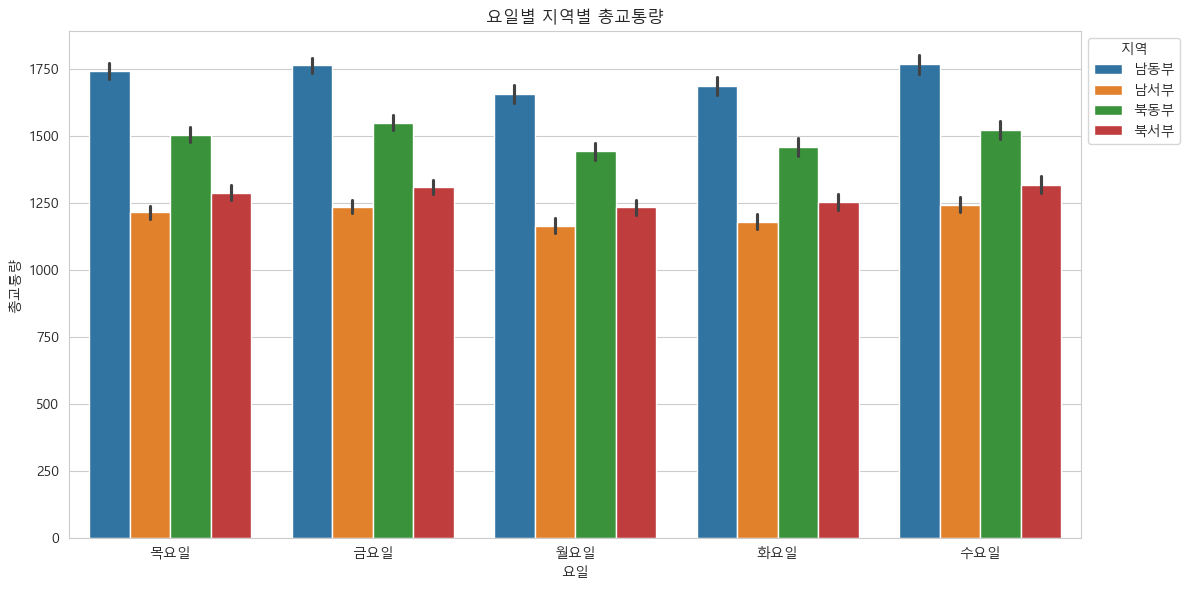

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ✅ 한글 깨짐 방지를 위한 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우
# plt.rcParams['font.family'] = 'AppleGothic' # 맥
plt.rcParams['axes.unicode_minus'] = False

df = region_gb
# ✅ barplot
plt.figure(figsize=(12,6))
sns.barplot(x='weekday', y='총교통량', hue='지역', data=df)

plt.title('요일별 지역별 총교통량')
plt.xlabel('요일')
plt.ylabel('총교통량')

# ✅ 범례를 그래프 밖 오른쪽 위로
plt.legend(title='지역', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

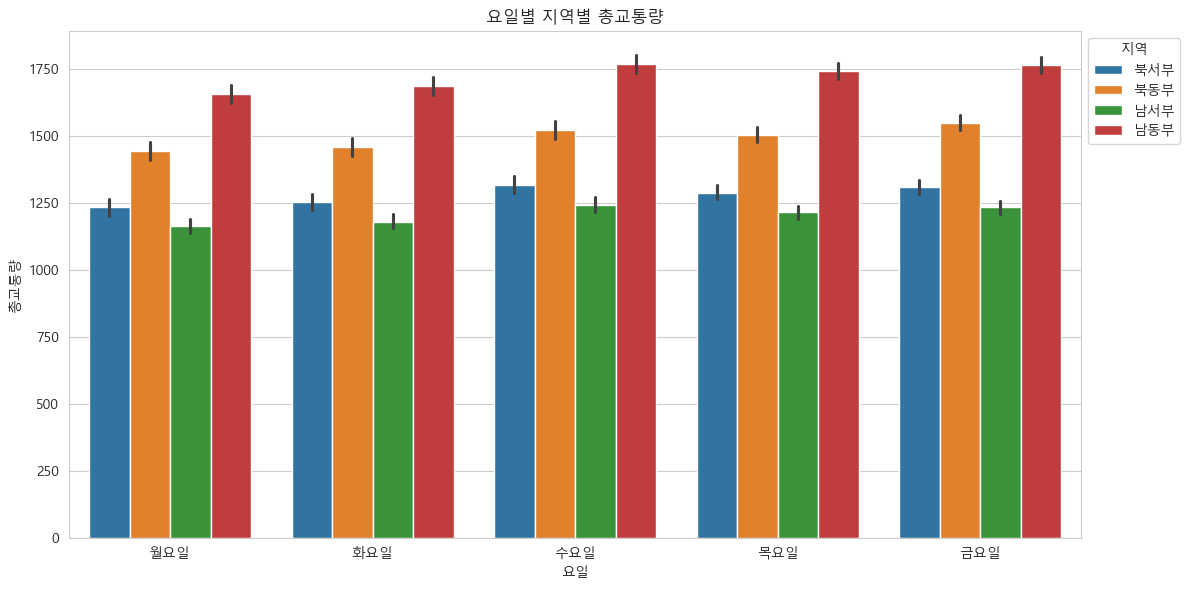

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 한글 깨짐 방지를 위한 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우
# plt.rcParams['font.family'] = 'AppleGothic' # 맥
plt.rcParams['axes.unicode_minus'] = False

# ✅ 데이터 정렬
weekday_order = ['월요일', '화요일', '수요일', '목요일', '금요일']
region_order = ['북서부', '북동부', '남서부', '남동부']

df['weekday'] = pd.Categorical(df['weekday'], categories=weekday_order, ordered=True)
df['지역'] = pd.Categorical(df['지역'], categories=region_order, ordered=True)

# ✅ barplot
plt.figure(figsize=(12,6))
sns.barplot(x='weekday', y='총교통량', hue='지역', data=df)

plt.title('요일별 지역별 총교통량')
plt.xlabel('요일')
plt.ylabel('총교통량')

# ✅ 범례를 그래프 밖 오른쪽 위로
plt.legend(title='지역', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()


C:\Users\s2arora\AppData\Local\Temp\ipykernel_32336\3288718706.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  commute_summary = commute_df.groupby(["지역"])["총교통량"].sum().reset_index()
C:\Users\s2arora\AppData\Local\Temp\ipykernel_32336\3288718706.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  leave_summary = leave_df.groupby(["지역"])["총교통량"].sum().reset_index()


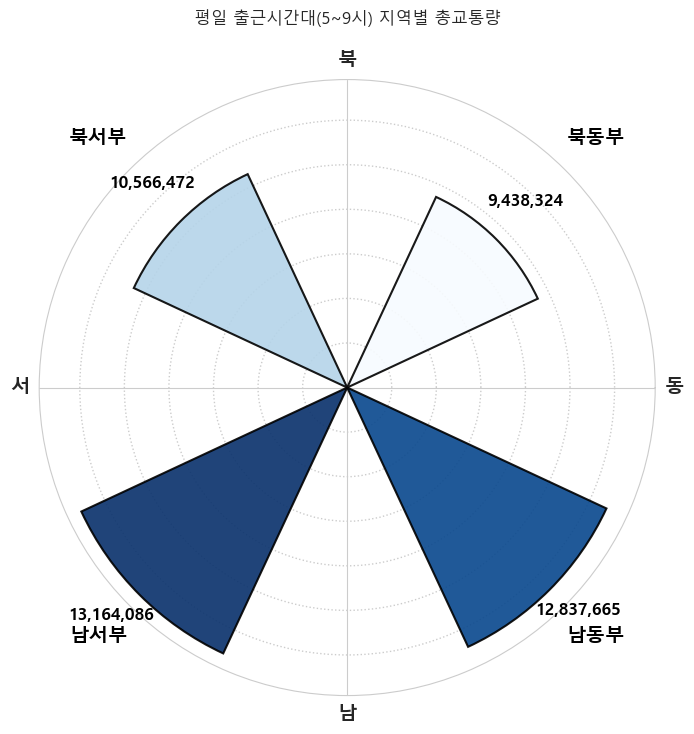

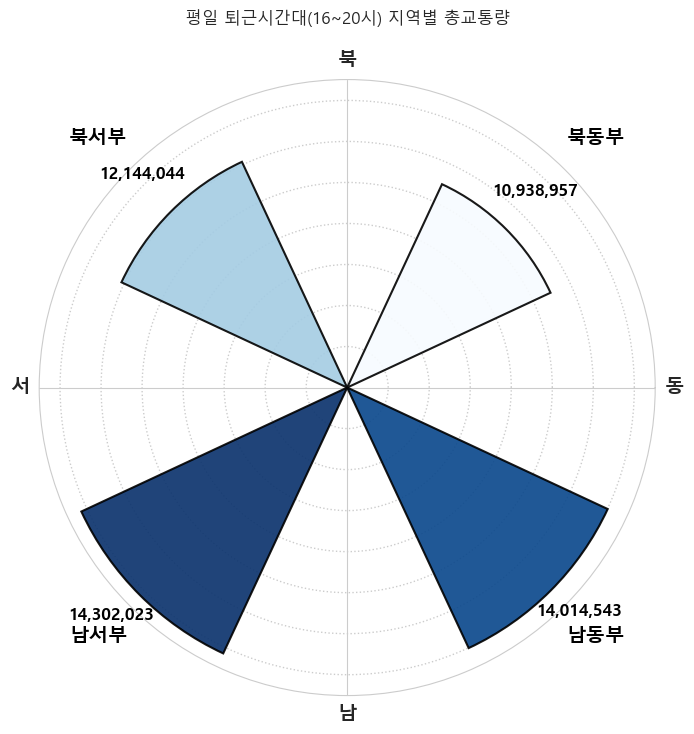

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ✅ 데이터 불러오기 및 전처리 (동일)
df = region_gb.copy()
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

day_map = {
    "Monday": "월요일",
    "Tuesday": "화요일",
    "Wednesday": "수요일",
    "Thursday": "목요일",
    "Friday": "금요일",
    "Saturday": "토요일",
    "Sunday": "일요일"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# ✅ 평일만 필터링
weekdays_df = df[df["weekday"].isin(["월요일", "화요일", "수요일", "목요일", "금요일"])]

# ✅ 출근시간대
commute_hours = [5,6,7,8,9]
commute_df = weekdays_df[weekdays_df["hour"].isin(commute_hours)]

commute_summary = commute_df.groupby(["지역"])["총교통량"].sum().reset_index()
commute_summary = commute_summary.sort_values(["총교통량"], ascending=[False])

# ✅ 퇴근시간대
leave_hours = [16,17,18,19,20]
leave_df = weekdays_df[weekdays_df["hour"].isin(leave_hours)]

leave_summary = leave_df.groupby(["지역"])["총교통량"].sum().reset_index()
leave_summary = leave_summary.sort_values(["총교통량"], ascending=[False])

# ✅ Polar plot 함수
def plot_polar_region(data, title):
    angle_map = {'남동부': 315, '북동부': 45, '북서부': 135, '남서부': 225}
    angles = [np.deg2rad(angle_map[area]) for area in data['지역']]
    traffic = data['총교통량']
    norm_traffic = (traffic - min(traffic)) / (max(traffic) - min(traffic))
    
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111, polar=True)

    for angle, height, norm_val in zip(angles, traffic, norm_traffic):
        ax.bar(angle, height, width=np.deg2rad(40), 
               color=plt.cm.Blues(norm_val), 
               edgecolor='black', linewidth=1.5, 
               align='center', alpha=0.9)

    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
    ax.set_xticklabels(['동', '북', '서', '남'], fontsize=14, fontweight='bold')

    for area, angle_deg in angle_map.items():
        angle_rad = np.deg2rad(angle_deg)
        r = max(traffic) * 1.2
        ax.text(angle_rad, r, area, ha='center', va='center', 
                fontsize=14, color='black', fontweight='bold')

    for angle, height in zip(angles, traffic):
        ax.text(angle, height + (max(traffic)*0.14), f'{height:,.0f}', 
                ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

    ax.yaxis.grid(True, linestyle=':', linewidth=1)
    ax.set_yticklabels([])

    plt.title(title, pad=20)
    plt.show()

# ✅ 그래프 그리기
plot_polar_region(commute_summary, "평일 출근시간대(5~9시) 지역별 총교통량")
plot_polar_region(leave_summary, "평일 퇴근시간대(16~20시) 지역별 총교통량")


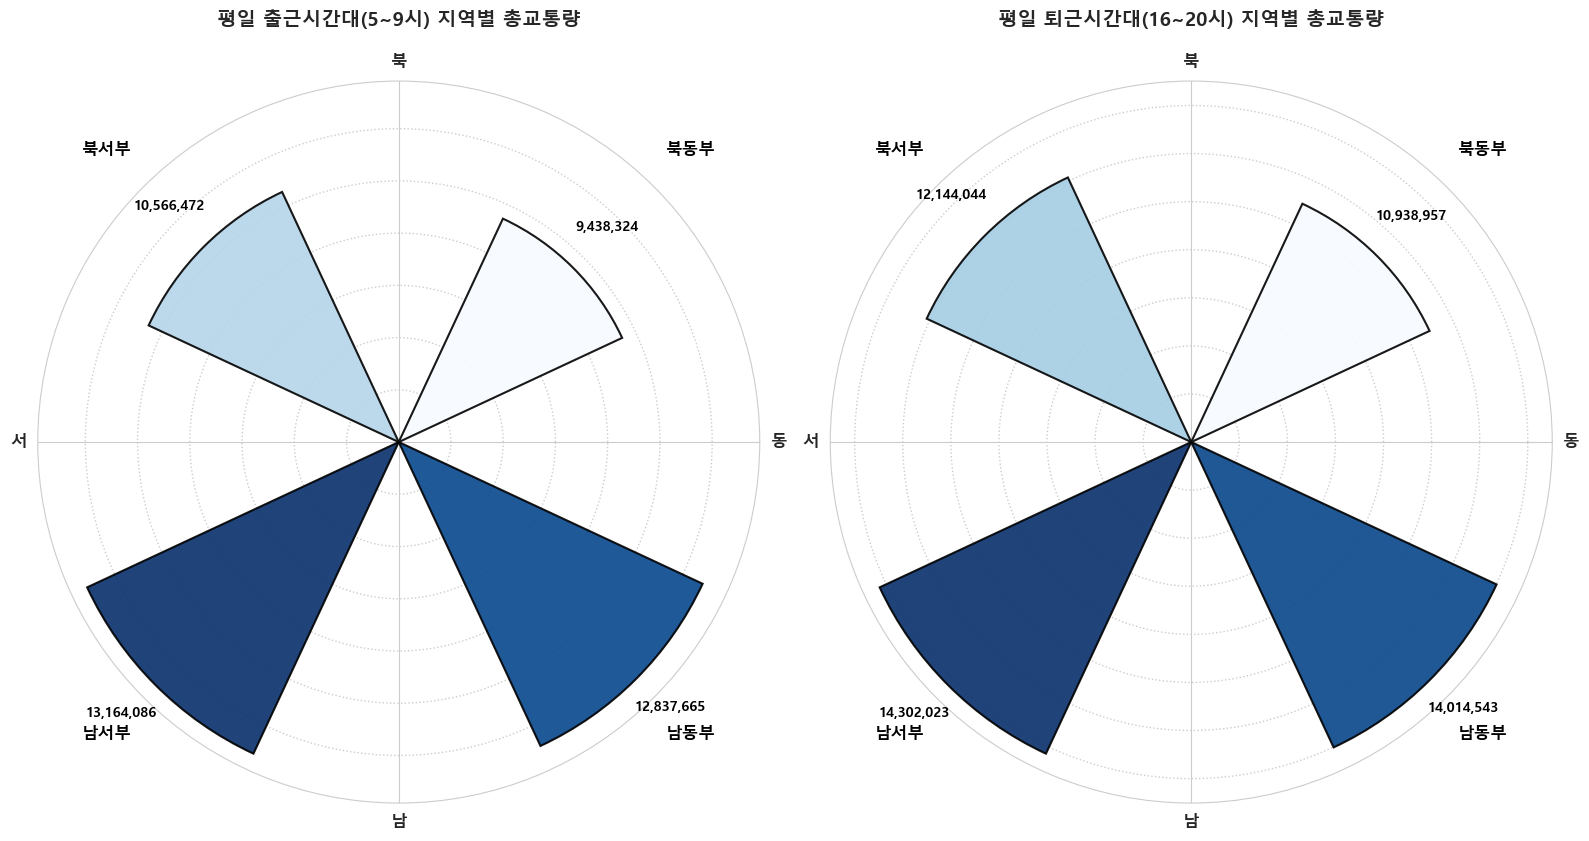

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ✅ 데이터 불러오기 및 전처리 (동일)
df = region_gb.copy()
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

day_map = {
    "Monday": "월요일",
    "Tuesday": "화요일",
    "Wednesday": "수요일",
    "Thursday": "목요일",
    "Friday": "금요일",
    "Saturday": "토요일",
    "Sunday": "일요일"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# ✅ 평일만 필터링
weekdays_df = df[df["weekday"].isin(["월요일", "화요일", "수요일", "목요일", "금요일"])]

# ✅ 출근시간대
commute_hours = [5,6,7,8,9]
commute_df = weekdays_df[weekdays_df["hour"].isin(commute_hours)]
commute_summary = commute_df.groupby(["지역"])["총교통량"].sum().reset_index()
commute_summary = commute_summary.sort_values(["총교통량"], ascending=[False])

# ✅ 퇴근시간대
leave_hours = [16,17,18,19,20]
leave_df = weekdays_df[weekdays_df["hour"].isin(leave_hours)]
leave_summary = leave_df.groupby(["지역"])["총교통량"].sum().reset_index()
leave_summary = leave_summary.sort_values(["총교통량"], ascending=[False])

# ✅ Polar plot 함수 (subplot용)
def plot_polar_region_subplot(ax, data, title):
    angle_map = {'남동부': 315, '북동부': 45, '북서부': 135, '남서부': 225}
    angles = [np.deg2rad(angle_map[area]) for area in data['지역']]
    traffic = data['총교통량']
    norm_traffic = (traffic - min(traffic)) / (max(traffic) - min(traffic))

    for angle, height, norm_val in zip(angles, traffic, norm_traffic):
        ax.bar(angle, height, width=np.deg2rad(40), 
               color=plt.cm.Blues(norm_val), 
               edgecolor='black', linewidth=1.5, 
               align='center', alpha=0.9)

    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
    ax.set_xticklabels(['동', '북', '서', '남'], fontsize=12, fontweight='bold')

    for area, angle_deg in angle_map.items():
        angle_rad = np.deg2rad(angle_deg)
        r = max(traffic) * 1.2
        ax.text(angle_rad, r, area, ha='center', va='center', 
                fontsize=12, color='black', fontweight='bold')

    for angle, height in zip(angles, traffic):
        ax.text(angle, height + (max(traffic)*0.14), f'{height:,.0f}', 
                ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

    ax.yaxis.grid(True, linestyle=':', linewidth=1)
    ax.set_yticklabels([])
    ax.set_title(title, pad=20, fontsize=14, fontweight='bold')

# ✅ 두 그래프 나란히 출력
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(16,8))

plot_polar_region_subplot(axes[0], commute_summary, "평일 출근시간대(5~9시) 지역별 총교통량")
plot_polar_region_subplot(axes[1], leave_summary, "평일 퇴근시간대(16~20시) 지역별 총교통량")

plt.tight_layout()
plt.show()


C:\Users\s2arora\AppData\Local\Temp\ipykernel_32336\2192398344.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_summary = df_sub.groupby(["지역"])["총교통량"].median().reset_index()


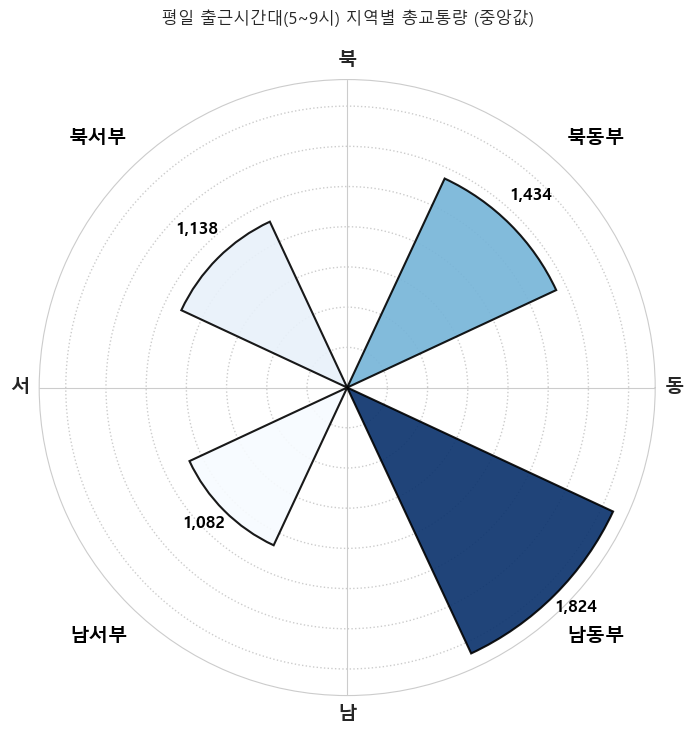

C:\Users\s2arora\AppData\Local\Temp\ipykernel_32336\2192398344.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_summary = df_sub.groupby(["지역"])["총교통량"].median().reset_index()


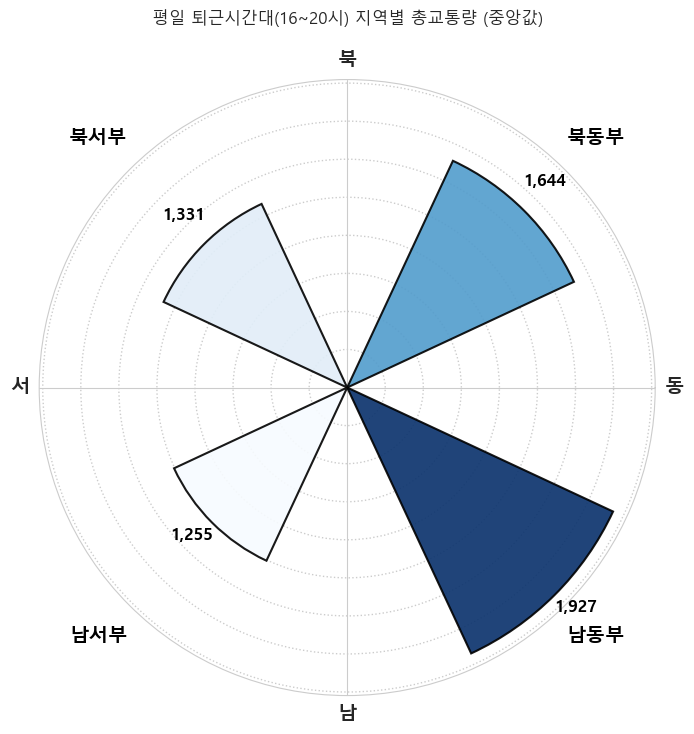

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 데이터 불러오기
df = region_gb.copy()

# 날짜형식 변환 및 요일 컬럼 추가
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

# 영어 -> 한글 요일 변환
day_map = {
    "Monday": "월요일",
    "Tuesday": "화요일",
    "Wednesday": "수요일",
    "Thursday": "목요일",
    "Friday": "금요일",
    "Saturday": "토요일",
    "Sunday": "일요일"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# 평일만 필터링
week_df = df[df["weekday"].isin(["월요일", "화요일", "수요일", "목요일", "금요일"])]

# ✅ Polar plot 함수
def plot_polar_median(df_sub, title):
    region_summary = df_sub.groupby(["지역"])["총교통량"].median().reset_index()
    region_summary = region_summary.sort_values(["총교통량"], ascending=False)

    angle_map = {'남동부': 315, '북동부': 45, '북서부': 135, '남서부': 225}
    angles = [np.deg2rad(angle_map[area]) for area in region_summary['지역']]
    traffic = region_summary['총교통량']
    norm_traffic = (traffic - min(traffic)) / (max(traffic) - min(traffic))

    plt.figure(figsize=(8,8))
    ax = plt.subplot(111, polar=True)

    # 막대
    for angle, height, norm_val in zip(angles, traffic, norm_traffic):
        ax.bar(angle, height, width=np.deg2rad(40),
               color=plt.cm.Blues(norm_val),
               edgecolor='black', linewidth=1.5,
               align='center', alpha=0.9)

    # 동서남북 라벨
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
    ax.set_xticklabels(['동', '북', '서', '남'], fontsize=14, fontweight='bold')

    # 대각선 방위 라벨
    for area, angle_deg in angle_map.items():
        angle_rad = np.deg2rad(angle_deg)
        r = max(traffic) * 1.2
        ax.text(angle_rad, r, area, ha='center', va='center',
                fontsize=14, color='black', fontweight='bold')

    # 막대 위 값
    for angle, height in zip(angles, traffic):
        ax.text(angle, height + (max(traffic)*0.1), f'{height:,.0f}',
                ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

    # 반지름 눈금 점선으로
    ax.yaxis.grid(True, linestyle=':', linewidth=1)
    ax.set_yticklabels([])

    plt.title(title, pad=20)
    plt.show()

# ✅ 출근시간대 (5~9시)
commute_df = week_df[week_df["hour"].isin([5,6,7,8,9])]
plot_polar_median(commute_df, "평일 출근시간대(5~9시) 지역별 총교통량 (중앙값)")

# ✅ 퇴근시간대 (16~20시)
leave_df = week_df[week_df["hour"].isin([16,17,18,19,20])]
plot_polar_median(leave_df, "평일 퇴근시간대(16~20시) 지역별 총교통량 (중앙값)")


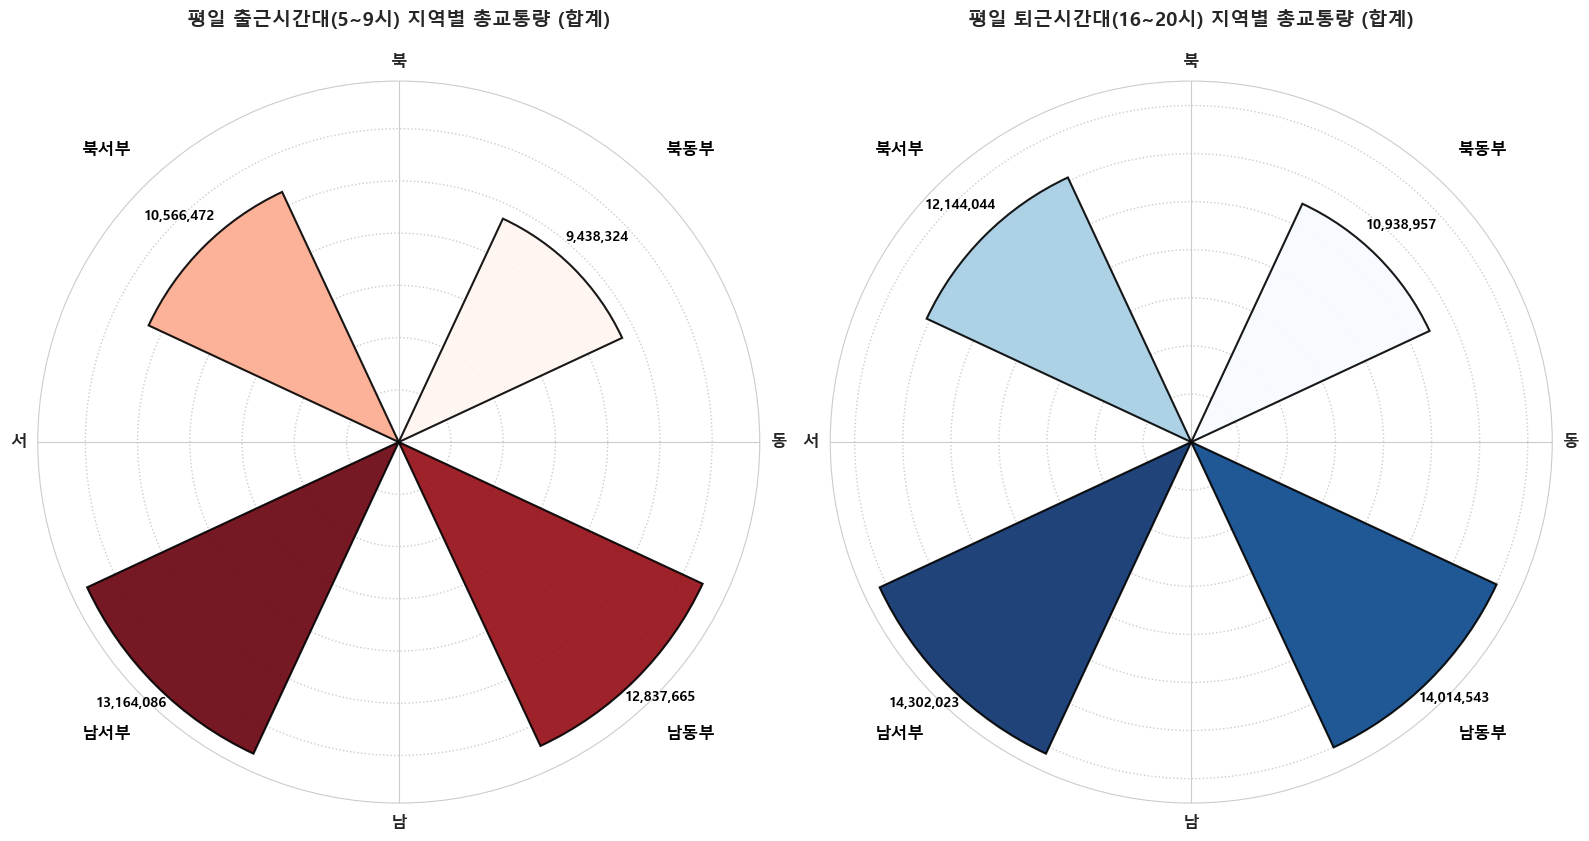

In [171]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 데이터 불러오기
df = region_gb.copy()

# 날짜형식 변환 및 요일 컬럼 추가
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

day_map = {
    "Monday": "월요일",
    "Tuesday": "화요일",
    "Wednesday": "수요일",
    "Thursday": "목요일",
    "Friday": "금요일",
    "Saturday": "토요일",
    "Sunday": "일요일"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# 평일만 필터링
week_df = df[df["weekday"].isin(["월요일", "화요일", "수요일", "목요일", "금요일"])]

# ✅ subplot용 Polar plot 함수 (색상맵 선택 가능)
def plot_polar_sum_subplot(ax, df_sub, title, cmap):
    region_summary = df_sub.groupby(["지역"])["총교통량"].sum().reset_index()
    region_summary = region_summary.sort_values(["총교통량"], ascending=False)

    angle_map = {'남동부': 315, '북동부': 45, '북서부': 135, '남서부': 225}
    angles = [np.deg2rad(angle_map[area]) for area in region_summary['지역']]
    traffic = region_summary['총교통량']
    norm_traffic = (traffic - min(traffic)) / (max(traffic) - min(traffic))

    for angle, height, norm_val in zip(angles, traffic, norm_traffic):
        ax.bar(angle, height, width=np.deg2rad(40),
               color=cmap(norm_val),
               edgecolor='black', linewidth=1.5,
               align='center', alpha=0.9)

    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
    ax.set_xticklabels(['동', '북', '서', '남'], fontsize=12, fontweight='bold')

    for area, angle_deg in angle_map.items():
        angle_rad = np.deg2rad(angle_deg)
        r = max(traffic) * 1.2
        ax.text(angle_rad, r, area, ha='center', va='center',
                fontsize=12, color='black', fontweight='bold')

    for angle, height in zip(angles, traffic):
        ax.text(angle, height + (max(traffic)*0.1), f'{height:,.0f}',
                ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

    ax.yaxis.grid(True, linestyle=':', linewidth=1)
    ax.set_yticklabels([])
    ax.set_title(title, pad=20, fontsize=14, fontweight='bold')

# ✅ 출근/퇴근 데이터
commute_df = week_df[week_df["hour"].isin([5,6,7,8,9])]
leave_df = week_df[week_df["hour"].isin([16,17,18,19,20])]

# ✅ 나란히 출력 (출근은 Reds, 퇴근은 Blues)
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(16,8))

plot_polar_sum_subplot(axes[0], commute_df, "평일 출근시간대(5~9시) 지역별 총교통량 (합계)", plt.cm.Reds)
plot_polar_sum_subplot(axes[1], leave_df, "평일 퇴근시간대(16~20시) 지역별 총교통량 (합계)", plt.cm.Blues)

plt.tight_layout()
plt.show()


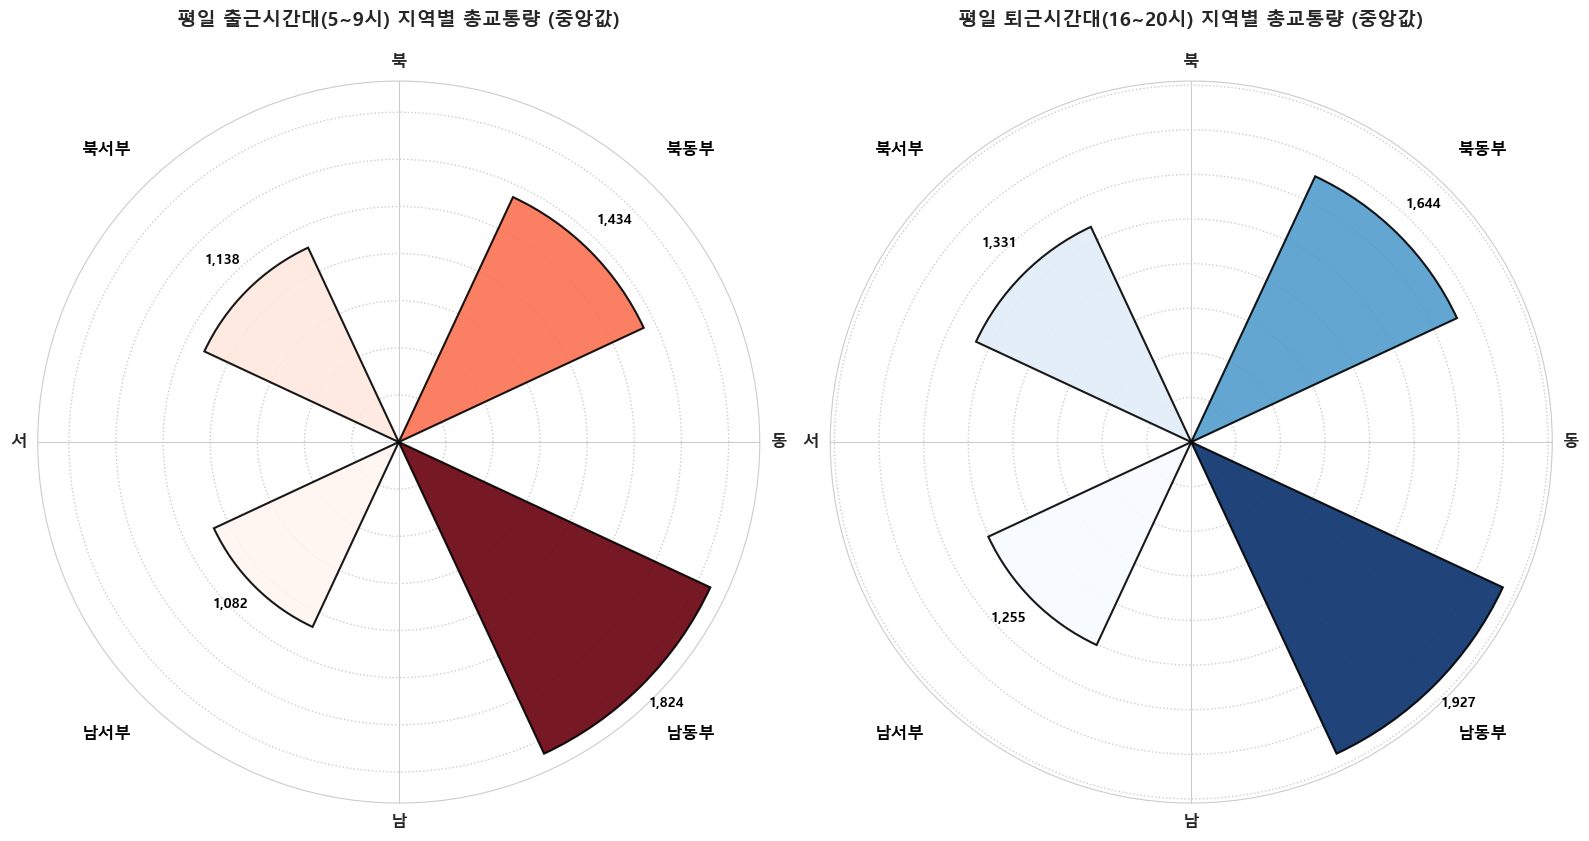

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 데이터 불러오기
df = region_gb.copy()

# 날짜형식 변환 및 요일 컬럼 추가
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

day_map = {
    "Monday": "월요일",
    "Tuesday": "화요일",
    "Wednesday": "수요일",
    "Thursday": "목요일",
    "Friday": "금요일",
    "Saturday": "토요일",
    "Sunday": "일요일"
}
df["weekday"] = df["weekday_eng"].map(day_map)

# 평일만 필터링
week_df = df[df["weekday"].isin(["월요일", "화요일", "수요일", "목요일", "금요일"])]

# ✅ subplot용 Polar plot 함수 (colormap 선택 가능)
def plot_polar_median_subplot(ax, df_sub, title, cmap):
    region_summary = df_sub.groupby(["지역"])["총교통량"].median().reset_index()
    region_summary = region_summary.sort_values(["총교통량"], ascending=False)

    angle_map = {'남동부': 315, '북동부': 45, '북서부': 135, '남서부': 225}
    angles = [np.deg2rad(angle_map[area]) for area in region_summary['지역']]
    traffic = region_summary['총교통량']
    norm_traffic = (traffic - min(traffic)) / (max(traffic) - min(traffic))

    for angle, height, norm_val in zip(angles, traffic, norm_traffic):
        ax.bar(angle, height, width=np.deg2rad(40),
               color=cmap(norm_val),
               edgecolor='black', linewidth=1.5,
               align='center', alpha=0.9)

    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
    ax.set_xticklabels(['동', '북', '서', '남'], fontsize=12, fontweight='bold')

    for area, angle_deg in angle_map.items():
        angle_rad = np.deg2rad(angle_deg)
        r = max(traffic) * 1.2
        ax.text(angle_rad, r, area, ha='center', va='center',
                fontsize=12, color='black', fontweight='bold')

    for angle, height in zip(angles, traffic):
        ax.text(angle, height + (max(traffic)*0.1), f'{height:,.0f}',
                ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

    ax.yaxis.grid(True, linestyle=':', linewidth=1)
    ax.set_yticklabels([])
    ax.set_title(title, pad=20, fontsize=14, fontweight='bold')

# ✅ 출근/퇴근 데이터
commute_df = week_df[week_df["hour"].isin([5,6,7,8,9])]
leave_df = week_df[week_df["hour"].isin([16,17,18,19,20])]

# ✅ 나란히 출력 (출근은 Reds, 퇴근은 Blues)
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(16,8))

plot_polar_median_subplot(axes[0], commute_df, "평일 출근시간대(5~9시) 지역별 총교통량 (중앙값)", plt.cm.Reds)
plot_polar_median_subplot(axes[1], leave_df, "평일 퇴근시간대(16~20시) 지역별 총교통량 (중앙값)", plt.cm.Blues)

plt.tight_layout()
plt.show()


In [26]:
import pandas as pd

# 데이터 불러오기
df = region_gb

# 날짜형식 변환 및 요일 컬럼 추가 (영어로)
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["weekday_eng"] = df["date"].dt.day_name()

# 영어 -> 한글 요일 변환
day_map = {
    "Monday": "월요일",
    "Tuesday": "화요일",
    "Wednesday": "수요일",
    "Thursday": "목요일",
    "Friday": "금요일",
    "Saturday": "토요일",
    "Sunday": "일요일"
}
df["weekday"] = df["weekday_eng"].map(day_map)


# 요일별 지역별 총교통량 집계
region_summary = weekend_df.groupby(["weekday", "지역",'구'])["총교통량"].median().reset_index()
region_summary = region_summary.sort_values(["weekday", "총교통량"], ascending=[False, False])

# 요약 결과 확인
print(region_summary)


    weekday   지역    구    총교통량
191     화요일  북동부  구리시  3491.5
170     화요일  남동부  과천시  3333.0
204     화요일  북서부  마포구  2414.0
183     화요일  남서부  마포구  2329.0
200     화요일  북동부  중랑구  2000.0
..      ...  ...  ...     ...
41      금요일  북서부   중구   493.5
17      금요일  남서부  서초구   484.0
1       금요일  남동부  강동구   481.0
22      금요일  북동부  광진구   441.5
11      금요일  남서부  광명시    79.5

[210 rows x 4 columns]


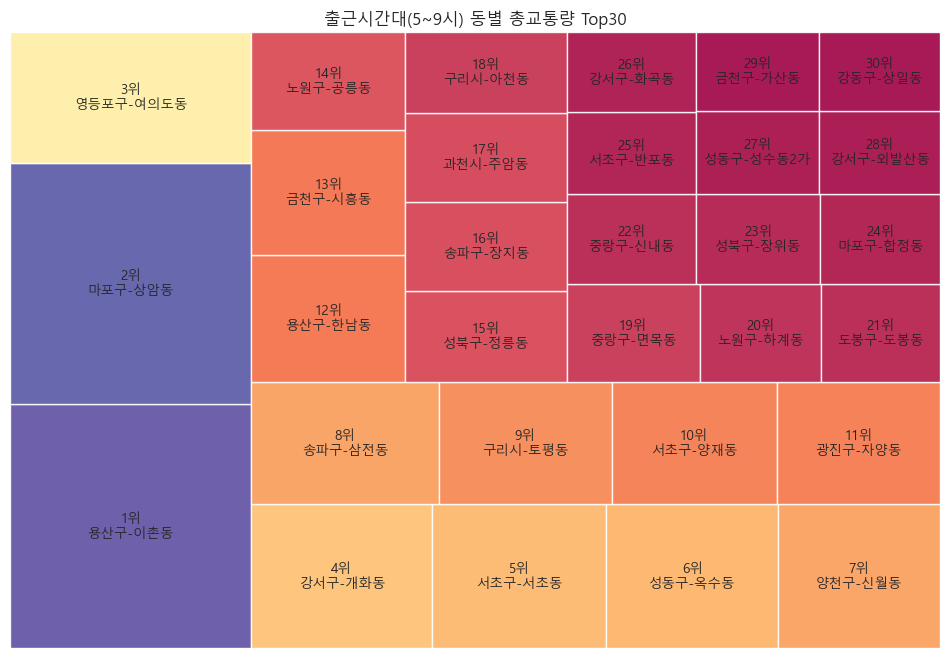

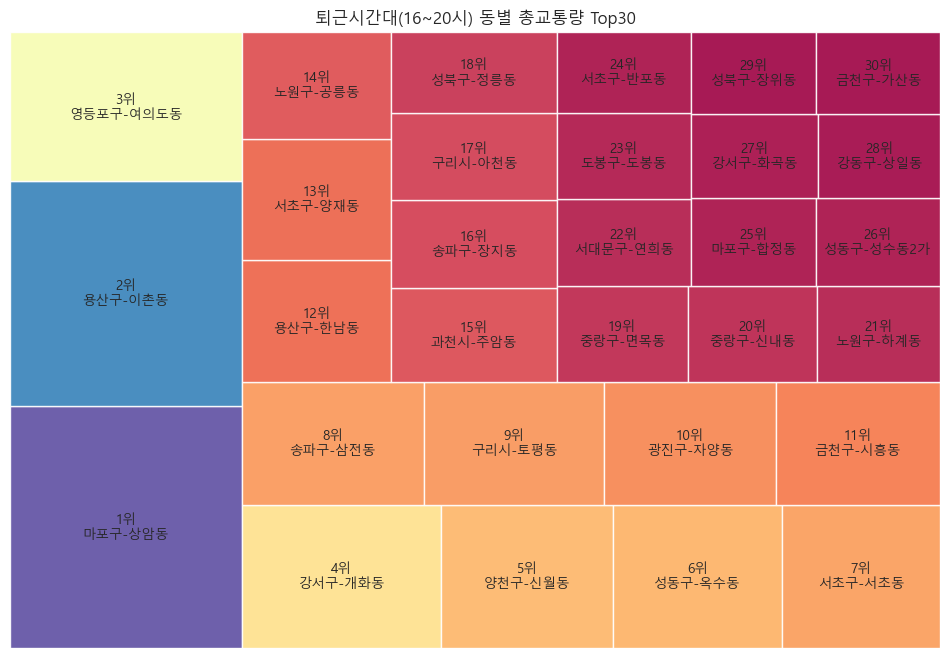

In [31]:
import squarify
import matplotlib.pyplot as plt
import numpy as np

# ✅ 출근시간대 (5~9시)
commute_df = week_df[week_df["hour"].isin([5,6,7,8,9])]
commute_summary = commute_df.groupby(["구", "동"]).agg({"총교통량":"sum"}).reset_index()
top30_commute = commute_summary.sort_values("총교통량", ascending=False).head(30).copy()
top30_commute["rank"] = range(1, len(top30_commute)+1)
top30_commute["라벨"] = top30_commute["rank"].astype(str) + "위\n" + top30_commute["구"] + "-" + top30_commute["동"]

# 컬러맵
norm_traffic = (top30_commute["총교통량"] - top30_commute["총교통량"].min()) / (top30_commute["총교통량"].max() - top30_commute["총교통량"].min())
colors = [plt.cm.Spectral(val) for val in norm_traffic]

plt.figure(figsize=(12,8))
squarify.plot(sizes=top30_commute["총교통량"], label=top30_commute["라벨"], 
              color=colors, alpha=0.9,  text_kwargs={'fontsize':9.7})
plt.axis('off')
plt.title("출근시간대(5~9시) 동별 총교통량 Top30")
plt.show()


# ✅ 퇴근시간대 (16~20시)
leave_df = week_df[week_df["hour"].isin([16,17,18,19,20])]
leave_summary = leave_df.groupby(["구", "동"]).agg({"총교통량":"sum"}).reset_index()
top30_leave = leave_summary.sort_values("총교통량", ascending=False).head(30).copy()
top30_leave["rank"] = range(1, len(top30_leave)+1)
top30_leave["라벨"] = top30_leave["rank"].astype(str) + "위\n" + top30_leave["구"] + "-" + top30_leave["동"]

# 컬러맵
norm_traffic = (top30_leave["총교통량"] - top30_leave["총교통량"].min()) / (top30_leave["총교통량"].max() - top30_leave["총교통량"].min())
colors = [plt.cm.Spectral(val) for val in norm_traffic]

plt.figure(figsize=(12,8))
squarify.plot(sizes=top30_leave["총교통량"], label=top30_leave["라벨"], 
              color=colors, alpha=0.9,  text_kwargs={'fontsize':9.7})
plt.axis('off')
plt.title("퇴근시간대(16~20시) 동별 총교통량 Top30")
plt.show()



C:\Users\s2arora\AppData\Local\Temp\ipykernel_32336\4208889161.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="구-동", x="총교통량", data=top10_commute, palette="Blues_d")
C:\Users\s2arora\AppData\Local\Temp\ipykernel_32336\4208889161.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="구-동", x="총교통량", data=top10_leave, palette="Oranges_d")


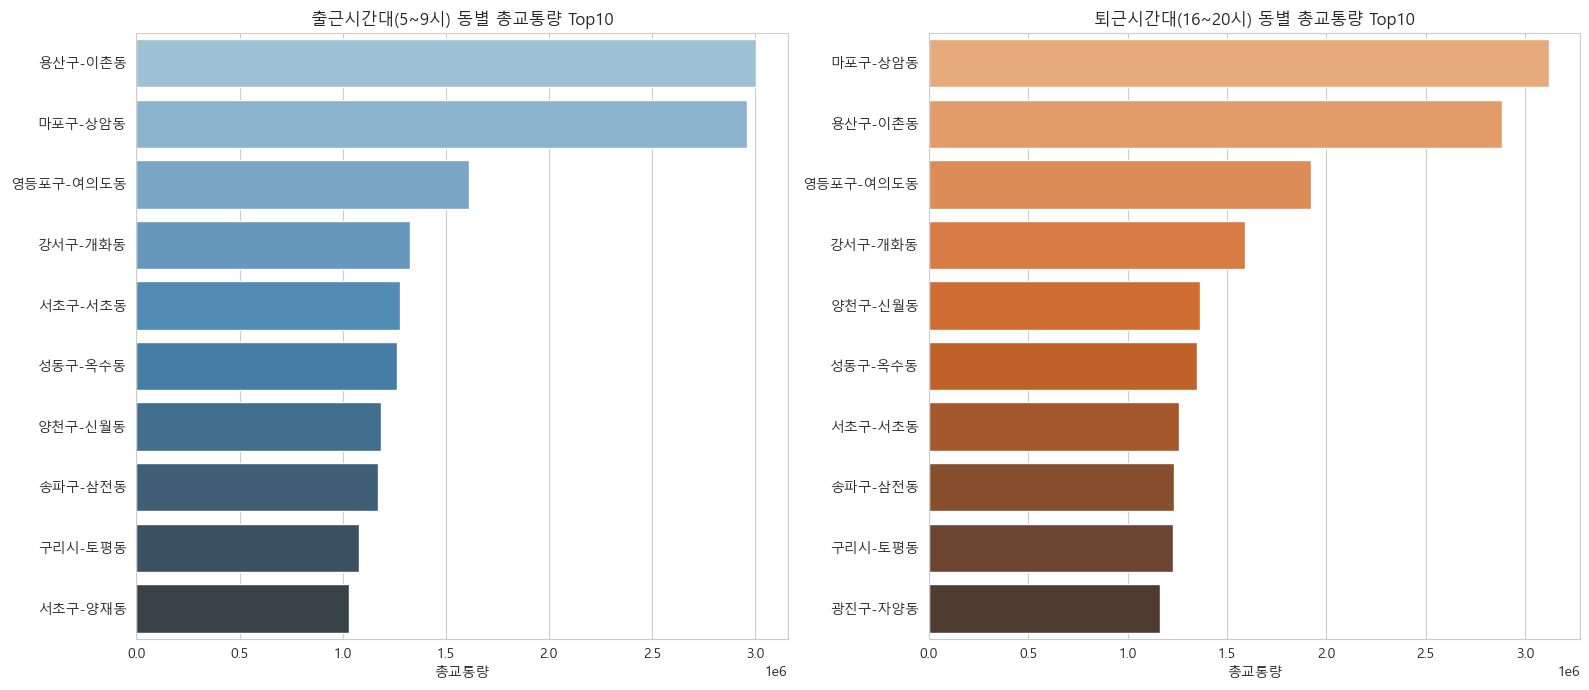

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 출근시간대 (5~9시)
commute_df = week_df[week_df["hour"].isin([5,6,7,8,9])]
commute_summary = commute_df.groupby(["구", "동"]).agg({"총교통량":"sum"}).reset_index()
top10_commute = commute_summary.sort_values("총교통량", ascending=False).head(10).copy()
top10_commute["구-동"] = top10_commute["구"] + "-" + top10_commute["동"]

# ✅ 퇴근시간대 (16~20시)
leave_df = week_df[week_df["hour"].isin([16,17,18,19,20])]
leave_summary = leave_df.groupby(["구", "동"]).agg({"총교통량":"sum"}).reset_index()
top10_leave = leave_summary.sort_values("총교통량", ascending=False).head(10).copy()
top10_leave["구-동"] = top10_leave["구"] + "-" + top10_leave["동"]

# ✅ subplot으로 barplot 나란히
plt.figure(figsize=(16,7))

# ▶ 출근시간대
plt.subplot(1,2,1)
sns.barplot(y="구-동", x="총교통량", data=top10_commute, palette="Blues_d")
plt.title("출근시간대(5~9시) 동별 총교통량 Top10")
plt.xlabel("총교통량")
plt.ylabel("")

# ▶ 퇴근시간대
plt.subplot(1,2,2)
sns.barplot(y="구-동", x="총교통량", data=top10_leave, palette="Oranges_d")
plt.title("퇴근시간대(16~20시) 동별 총교통량 Top10")
plt.xlabel("총교통량")
plt.ylabel("")

plt.tight_layout()
plt.show()



C:\Users\s2arora\AppData\Local\Temp\ipykernel_32336\946172442.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hourly_traffic, x="hour", y="총교통량", palette="viridis")


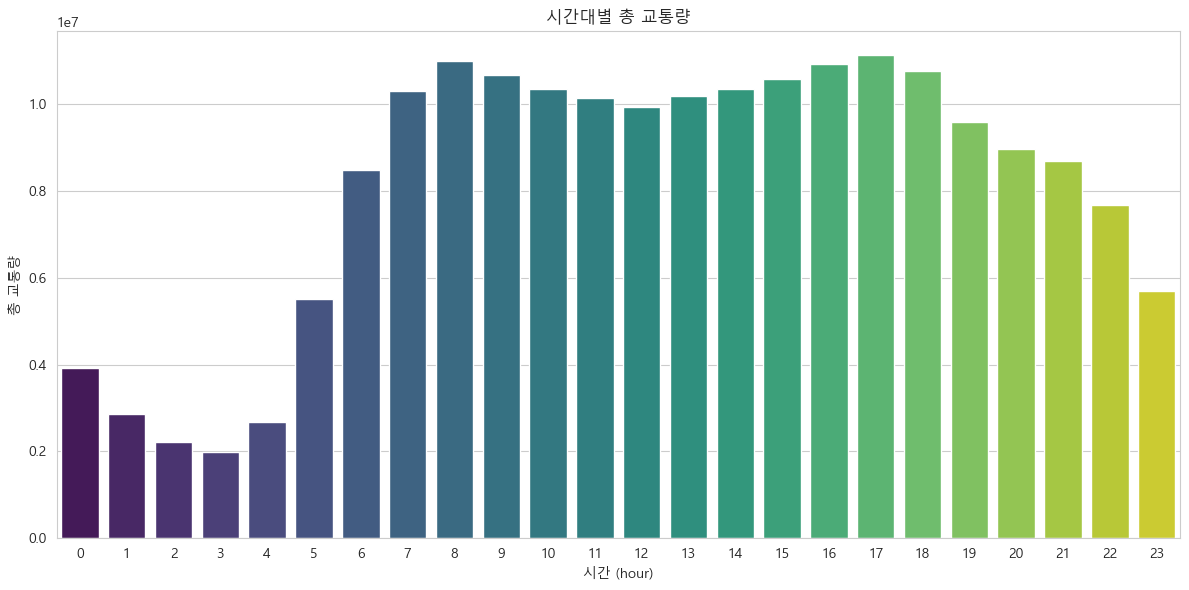

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시간별 총교통량 집계
hourly_traffic = df.groupby("hour")["총교통량"].sum().reset_index()

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=hourly_traffic, x="hour", y="총교통량", palette="viridis")
plt.title("시간대별 총 교통량")
plt.xlabel("시간 (hour)")
plt.ylabel("총 교통량")
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\s2arora\AppData\Local\Temp\ipykernel_32336\2409847033.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="spot_name", x="총교통량", data=top10_commute, palette="Blues_d")
C:\Users\s2arora\AppData\Local\Temp\ipykernel_32336\2409847033.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="spot_name", x="총교통량", data=top10_leave, palette="Oranges_d")


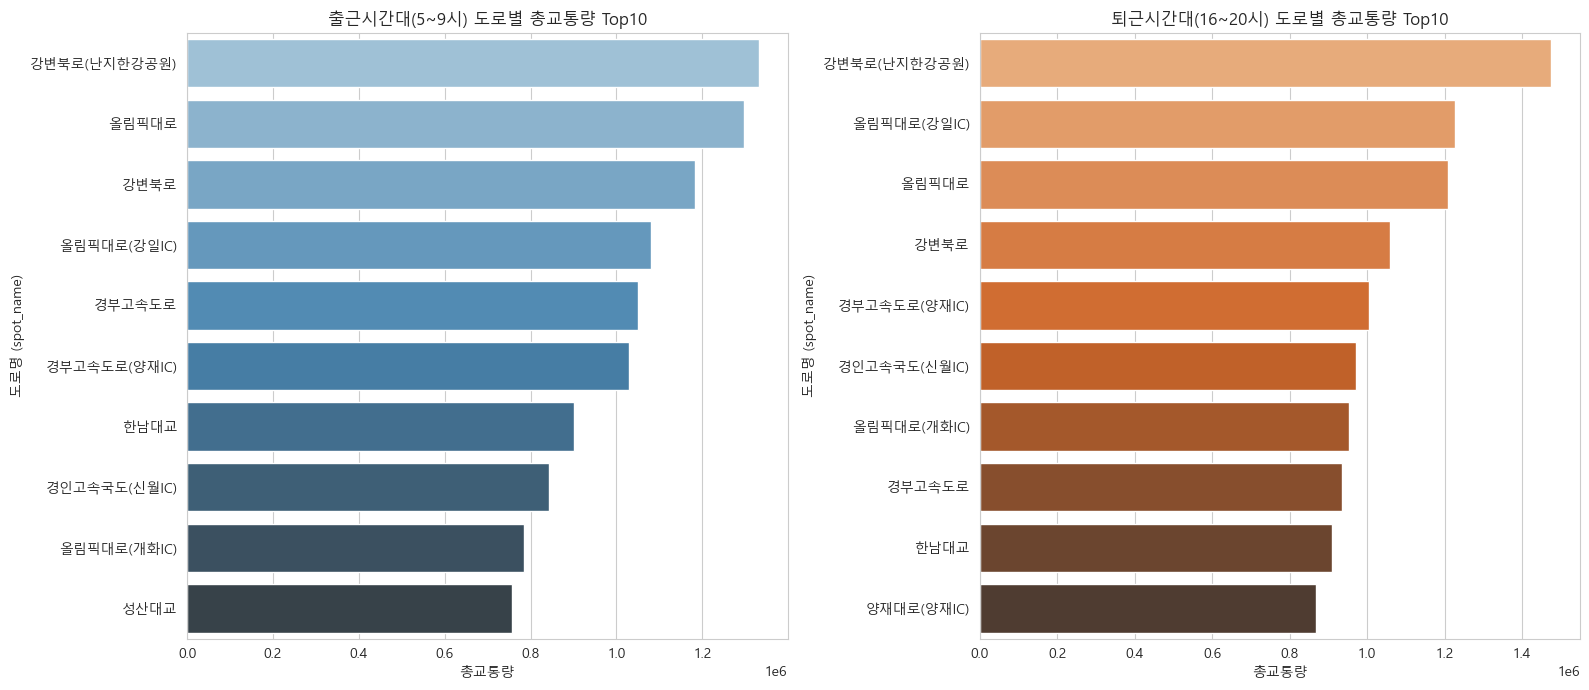

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 출근시간대 (5~9시)
commute_df = df[df["hour"].isin([5,6,7,8,9])]
commute_summary = commute_df.groupby("spot_name")["총교통량"].sum().reset_index()
top10_commute = commute_summary.sort_values("총교통량", ascending=False).head(10)

# ✅ 퇴근시간대 (16~20시)
leave_df = df[df["hour"].isin([16,17,18,19,20])]
leave_summary = leave_df.groupby("spot_name")["총교통량"].sum().reset_index()
top10_leave = leave_summary.sort_values("총교통량", ascending=False).head(10)

# ✅ subplot 으로 barplot 나란히
plt.figure(figsize=(16,7))

# ▶ 출근시간대
plt.subplot(1,2,1)
sns.barplot(y="spot_name", x="총교통량", data=top10_commute, palette="Blues_d")
plt.title("출근시간대(5~9시) 도로별 총교통량 Top10")
plt.xlabel("총교통량")
plt.ylabel("도로명 (spot_name)")

# ▶ 퇴근시간대
plt.subplot(1,2,2)
sns.barplot(y="spot_name", x="총교통량", data=top10_leave, palette="Oranges_d")
plt.title("퇴근시간대(16~20시) 도로별 총교통량 Top10")
plt.xlabel("총교통량")
plt.ylabel("도로명 (spot_name)")

plt.tight_layout()
plt.show()


In [38]:
from IPython.display import display

# ✅ 출근시간대 (5~9시)
commute_df = df[df["hour"].isin([5,6,7,8,9])]
commute_summary = commute_df.groupby("spot_name")["총교통량"].sum().reset_index()
top10_commute = commute_summary.sort_values("총교통량", ascending=False).head(10)
top10_commute = top10_commute.reset_index(drop=True)
top10_commute.index += 1  # 순위 표시

print("🚗 출근시간대(5~9시) 도로별 총교통량 Top10")
display(top10_commute)

# ✅ 퇴근시간대 (16~20시)
leave_df = df[df["hour"].isin([16,17,18,19,20])]
leave_summary = leave_df.groupby("spot_name")["총교통량"].sum().reset_index()
top10_leave = leave_summary.sort_values("총교통량", ascending=False).head(10)
top10_leave = top10_leave.reset_index(drop=True)
top10_leave.index += 1  # 순위 표시

print("🚗 퇴근시간대(16~20시) 도로별 총교통량 Top10")
display(top10_leave)



🚗 출근시간대(5~9시) 도로별 총교통량 Top10


,spot_name,총교통량
1,강변북로(난지한강공원),1331689
2,올림픽대로,1296795
3,강변북로,1183694
4,올림픽대로(강일IC),1081426
5,경부고속도로,1050911
6,경부고속도로(양재IC),1028921
7,한남대교,901245
8,경인고속국도(신월IC),843666
9,올림픽대로(개화IC),784197
10,성산대교,757488


🚗 퇴근시간대(16~20시) 도로별 총교통량 Top10


,spot_name,총교통량
1,강변북로(난지한강공원),1475869
2,올림픽대로(강일IC),1227635
3,올림픽대로,1208668
4,강변북로,1060315
5,경부고속도로(양재IC),1006245
6,경인고속국도(신월IC),971177
7,올림픽대로(개화IC),952623
8,경부고속도로,935513
9,한남대교,909161
10,양재대로(양재IC),867814


In [39]:
from IPython.display import display

# ✅ 출근시간대 (5~9시) - 중앙값
commute_df = df[df["hour"].isin([5,6,7,8,9])]
commute_summary_median = commute_df.groupby("spot_name")["총교통량"].median().reset_index()
top10_commute_median = commute_summary_median.sort_values("총교통량", ascending=False).head(10)
top10_commute_median = top10_commute_median.reset_index(drop=True)
top10_commute_median.index += 1  # 순위

print("🚗 출근시간대(5~9시) 도로별 총교통량 Top10 (중앙값 기준)")
display(top10_commute_median)

# ✅ 퇴근시간대 (16~20시) - 중앙값
leave_df = df[df["hour"].isin([16,17,18,19,20])]
leave_summary_median = leave_df.groupby("spot_name")["총교통량"].median().reset_index()
top10_leave_median = leave_summary_median.sort_values("총교통량", ascending=False).head(10)
top10_leave_median = top10_leave_median.reset_index(drop=True)
top10_leave_median.index += 1  # 순위

print("🚗 퇴근시간대(16~20시) 도로별 총교통량 Top10 (중앙값 기준)")
display(top10_leave_median)


🚗 출근시간대(5~9시) 도로별 총교통량 Top10 (중앙값 기준)


,spot_name,총교통량
1,강변북로(난지한강공원),6477.5
2,강변북로,5943.0
3,올림픽대로,5921.5
4,올림픽대로(강일IC),5574.0
5,경부고속도로,4874.0
6,경부고속도로(양재IC),4831.0
7,한남대교,4531.5
8,양재대로(양재IC),4174.0
9,경인고속국도(신월IC),3896.5
10,올림픽대로(개화IC),3777.0


🚗 퇴근시간대(16~20시) 도로별 총교통량 Top10 (중앙값 기준)


,spot_name,총교통량
1,강변북로(난지한강공원),6822.0
2,올림픽대로(강일IC),5843.5
3,올림픽대로,5383.0
4,강변북로,4859.5
5,경부고속도로(양재IC),4786.0
6,경부고속도로,4336.0
7,올림픽대로(개화IC),4276.5
8,한남대교,4268.0
9,경인고속국도(신월IC),4240.5
10,양재대로(양재IC),3748.0


In [ ]:
import pandas as pd
import numpy as np

# --------------------
# 출근시간대 TOP3 도착지 좌표
# --------------------
commute_df = df[df["hour"].isin([5,6,7,8,9])]
commute_top3 = commute_df.groupby("spot_name")[["총교통량"]].sum().reset_index()
commute_top3 = commute_top3.sort_values("총교통량", ascending=False).head(3)
commute_top3_coords = commute_df[commute_df["spot_name"].isin(commute_top3["spot_name"])][["spot_name","x","y"]].drop_duplicates()
print("출근시간대 최다 도착지 top3 좌표")
display(commute_top3_coords)

# --------------------
# 퇴근시간대 TOP3 출발지 좌표
# --------------------
leave_df = df[df["hour"].isin([16,17,18,19,20])]
leave_top3 = leave_df.groupby("spot_name")[["총교통량"]].sum().reset_index()
leave_top3 = leave_top3.sort_values("총교통량", ascending=False).head(3)
leave_top3_coords = leave_df[leave_df["spot_name"].isin(leave_top3["spot_name"])][["spot_name","x","y"]].drop_duplicates()
print("퇴근시간대 최다 출발지 top3 좌표")
display(leave_top3_coords)

# --------------------
# 주말 TOP3 경유지 (spot_name)
# --------------------
weekend_df = df[df["weekday"].isin(["Saturday", "Sunday"])]
weekend_top3 = weekend_df.groupby("spot_name")[["총교통량"]].sum().reset_index()
weekend_top3 = weekend_top3.sort_values("총교통량", ascending=False).head(3)
weekend_top3_coords = weekend_df[weekend_df["spot_name"].isin(weekend_top3["spot_name"])][["spot_name","x","y"]].drop_duplicates()
print("주말 최다 경유지 top3 좌표")
display(weekend_top3_coords)

# --------------------
# 서울을 대충 4분할
# --------------------
min_x, max_x = df["x"].min(), df["x"].max()
min_y, max_y = df["y"].min(), df["y"].max()

# 중간값 기준으로 나누기
mid_x = (min_x + max_x) / 2
mid_y = (min_y + max_y) / 2

# 각 사분면 데이터
q1 = df[(df["x"] >= mid_x) & (df["y"] >= mid_y)]
q2 = df[(df["x"] <  mid_x) & (df["y"] >= mid_y)]
q3 = df[(df["x"] <  mid_x) & (df["y"] <  mid_y)]
q4 = df[(df["x"] >= mid_x) & (df["y"] <  mid_y)]

# --------------------
# 평일 출근 출발지: 사분면 중 출근 top3 제외 랜덤 3곳
# --------------------
exclude_spots = commute_top3_coords["spot_name"].unique()

def get_random_point(df_quad, n=1):
    sample = df_quad[~df_quad["spot_name"].isin(exclude_spots)].sample(n)
    return sample[["spot_name","x","y"]]

print("출근 출발지 랜덤 3곳")
display(pd.concat([
    get_random_point(q1), get_random_point(q2), get_random_point(q3)
]))

# --------------------
# 평일 퇴근 도착지: 사분면 랜덤 3곳
print("퇴근 도착지 랜덤 3곳")
display(pd.concat([
    get_random_point(q1), get_random_point(q2), get_random_point(q3)
]))

# --------------------
# 주말 출발지: 사분면 랜덤 4곳
print("주말 출발지 랜덤 4곳")
display(pd.concat([
    get_random_point(q1), get_random_point(q2), get_random_point(q3), get_random_point(q4)
]))


In [42]:
from IPython.display import display
import pandas as pd
import numpy as np

# === 평일 데이터 ===
df 

# 출근시간대 top3 도착지
commute_df = df[df["hour"].isin([5,6,7,8,9])]
commute_top3 = commute_df.groupby("spot_name")["총교통량"].sum().reset_index().sort_values("총교통량", ascending=False).head(3)
commute_top3_coords = commute_df[commute_df["spot_name"].isin(commute_top3["spot_name"])][["spot_name","x","y"]].drop_duplicates()
print("🚗 출근시간대 top3 도착지")
display(commute_top3_coords)

# 퇴근시간대 top3 출발지
leave_df = df[df["hour"].isin([16,17,18,19,20])]
leave_top3 = leave_df.groupby("spot_name")["총교통량"].sum().reset_index().sort_values("총교통량", ascending=False).head(3)
leave_top3_coords = leave_df[leave_df["spot_name"].isin(leave_top3["spot_name"])][["spot_name","x","y"]].drop_duplicates()
print("🚗 퇴근시간대 top3 출발지")
display(leave_top3_coords)

# 서울 사분할 (중간 기준)
min_x, max_x = df["x"].min(), df["x"].max()
min_y, max_y = df["y"].min(), df["y"].max()
mid_x = (min_x + max_x) / 2
mid_y = (min_y + max_y) / 2

q1 = df[(df["x"] >= mid_x) & (df["y"] >= mid_y)]
q2 = df[(df["x"] <  mid_x) & (df["y"] >= mid_y)]
q3 = df[(df["x"] <  mid_x) & (df["y"] <  mid_y)]
q4 = df[(df["x"] >= mid_x) & (df["y"] <  mid_y)]

def get_random_point(df_quad, exclude_spots=None, n=1):
    if exclude_spots is not None:
        df_quad = df_quad[~df_quad["spot_name"].isin(exclude_spots)]
    return df_quad.sample(n)[["spot_name","x","y"]]

# 출근 출발지: top3 제외, 사분면 랜덤 3곳
print("🚀 출근 출발지 랜덤 3곳 (top3 제외)")
display(pd.concat([
    get_random_point(q1, exclude_spots=commute_top3_coords["spot_name"].unique()),
    get_random_point(q2, exclude_spots=commute_top3_coords["spot_name"].unique()),
    get_random_point(q3, exclude_spots=commute_top3_coords["spot_name"].unique())
]))

# 퇴근 도착지: 사분면 랜덤 3곳
print("🚀 퇴근 도착지 랜덤 3곳")
display(pd.concat([
    get_random_point(q1),
    get_random_point(q2),
    get_random_point(q3)
]))


🚗 출근시간대 top3 도착지


,spot_name,x,y
1494,강변북로,790916.0,1785580.0
1498,올림픽대로,988230.0,2225940.0
1499,올림픽대로,790584.0,1780752.0
1402,강변북로(난지한강공원),943695.0,2261890.0


🚗 퇴근시간대 top3 출발지


,spot_name,x,y
4351,올림픽대로,988230.0,2225940.0
4352,올림픽대로,790584.0,1780752.0
4221,올림픽대로(강일IC),855576.0,1809060.0
4257,강변북로(난지한강공원),943695.0,2261890.0


🚀 출근 출발지 랜덤 3곳 (top3 제외)


,spot_name,x,y
117120,양재대로(양재IC),1.421707e+06,3.080588e+06
90913,세종대로(시청역2),1.187900e+06,2.712040e+06
65072,개봉로(개봉교),3.746042e+05,8.860625e+05


🚀 퇴근 도착지 랜덤 3곳


,spot_name,x,y
102362,천호대로(상일IC),1.723757e+06,3.598189e+06
93971,세종대로(시청역2),1.187900e+06,2.712040e+06
111581,경인로(오류IC),5.604721e+05,1.333035e+06


In [147]:
# 출근시간대 top3 도착지
commute_top3_full = commute_df.groupby("spot_name")["총교통량"].sum().reset_index()
commute_top3_full = commute_top3_full.sort_values("총교통량", ascending=False).head(3)
commute_top3_full["등수"] = range(1, len(commute_top3_full)+1)

# 좌표 결합
commute_top3_coords_full = commute_df[commute_df["spot_name"].isin(commute_top3_full["spot_name"])]
commute_top3_coords_full = commute_top3_coords_full[["spot_name","x","y"]].drop_duplicates()

# merge해서 등수 & 총교통량 붙이기
commute_top3_table = pd.merge(commute_top3_coords_full, commute_top3_full, on="spot_name")

print("🚗 출근시간대 top3 도착지 (등수, 총교통량)")
display(commute_top3_table[["등수","spot_name","총교통량","x","y"]].sort_values("등수"))


🚗 출근시간대 top3 도착지 (등수, 총교통량)


,등수,spot_name,총교통량,x,y
3,1,강변북로(난지한강공원),1331689,943695.0,2261890.0
1,2,올림픽대로,1296795,988230.0,2225940.0
2,2,올림픽대로,1296795,790584.0,1780752.0
0,3,강변북로,1183694,790916.0,1785580.0
